<a href="https://colab.research.google.com/github/priyanshu2112032/JobSaathi/blob/master/GAN%20Art%20generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
pip install opendatasets --upgrade

In [2]:
import opendatasets as od
dataset_url = 'https://www.kaggle.com/datasets/priyanshu092632/nude-art-paintings/data'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: priyanshu092632
Your Kaggle Key: ··········


100%|██████████| 1.75G/1.75G [00:25<00:00, 74.6MB/s]


In [3]:
import os
DATA_DIR='./nude-art-paintings/'
print(os.listdir(DATA_DIR))


['nude-painting-nu']


# New Section

In [4]:
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
import torchvision.transforms as T


In [5]:
image_size=64
batch_size=128
stats=(0.5, 0.5, 0.5), (0.5, 0.5, 0.5)

In [6]:
train_ds=ImageFolder(DATA_DIR, transform=T.Compose([#train dataset
    T.Resize(image_size),
    T.CenterCrop(image_size),
    T.ToTensor(),
    T.Normalize(*stats)]
))

train_dl=DataLoader(train_ds,batch_size,shuffle=True,num_workers=2, pin_memory=True)

In [7]:
import torch
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
%matplotlib inline

In [8]:

def denorm(img_tensors):
    return img_tensors * stats[1][0] + stats[0][0]

In [9]:
def show_images(images, nmax=64):
    fig, ax = plt.subplots(figsize=(8, 8))
    ax.set_xticks([]); ax.set_yticks([])
    ax.imshow(make_grid(denorm(images.detach()[:nmax]), nrow=8).permute(1, 2, 0))

def show_batch(dl, nmax=64):
    for images, _ in dl:
        show_images(images, nmax)
        break

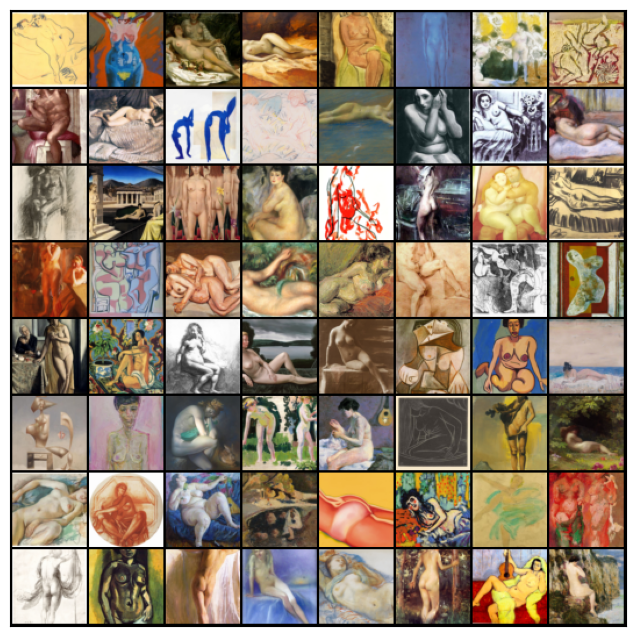

In [10]:
show_batch(train_dl)


In [11]:
!pip install jovian --upgrade --quiet


     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 68.6/68.6 kB 2.1 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [12]:
import jovian


In [13]:
jovian.commit(project='GAN-art', environment=None)


[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


In [14]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')

def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device

    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl:
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

In [15]:
device=get_default_device()
device

device(type='cuda')

In [16]:
train_dl=DeviceDataLoader(train_dl,device)

In [17]:
import torch.nn as nn

In [18]:
discriminator=nn.Sequential(


    nn.Conv2d(3,64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(64,128,kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(128,256,kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(256,512,kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(512),
    nn.LeakyReLU(0.2,inplace=True),

    nn.Conv2d(512,1,kernel_size=4, stride=1, padding=0, bias=False),

    nn.Flatten(),
    nn.Sigmoid()

)

In [19]:
discriminator=to_device(discriminator, device)

In [20]:
latent_size=128

In [21]:
generator =nn.Sequential(
    #in: latent_sizeX1X1

    nn.ConvTranspose2d(latent_size, 512, kernel_size=4, stride=1, padding=0, bias=False),
    nn.BatchNorm2d(512),
    nn.ReLU(True),

    # nn.ConvTranspose2d(512, 512, kernel_size=4, stride=1, padding=0, bias=False),
    # nn.BatchNorm2d(512),
    # nn.ReLU(True),
    #out: 512x4x4

    nn.ConvTranspose2d(512, 256, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(256),
    nn.ReLU(True),
    #out: 256x8x8

    nn.ConvTranspose2d(256, 128, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(128),
    nn.ReLU(True),
    #out: 128x16x16

    nn.ConvTranspose2d(128, 64, kernel_size=4, stride=2, padding=1, bias=False),
    nn.BatchNorm2d(64),
    nn.ReLU(True),
    #out: 64x32x32

    nn.ConvTranspose2d(64, 3, kernel_size=4, stride=2, padding=1, bias=False),
    nn.Tanh()

    #out: 3x64x64
)

In [22]:
generator=to_device(generator,device)

In [23]:
def train_discriminator(real_images, opt_d):
    # Clear discriminator gradients
    opt_d.zero_grad()

    # Pass real images through discriminator
    real_preds = discriminator(real_images)
    real_targets = torch.ones(real_images.size(0), 1, device=device)
    real_loss = F.binary_cross_entropy(real_preds, real_targets)
    real_score = torch.mean(real_preds).item()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Pass fake images through discriminator
    fake_targets = torch.zeros(fake_images.size(0), 1, device=device)
    fake_preds = discriminator(fake_images)
    fake_loss = F.binary_cross_entropy(fake_preds, fake_targets)
    fake_score = torch.mean(fake_preds).item()

    # Update discriminator weights
    loss = real_loss + fake_loss
    loss.backward()
    opt_d.step()
    return loss.item(), real_score, fake_score

In [24]:
def train_generator(opt_g):
    # Clear generator gradients
    opt_g.zero_grad()

    # Generate fake images
    latent = torch.randn(batch_size, latent_size, 1, 1, device=device)
    fake_images = generator(latent)

    # Try to fool the discriminator
    preds = discriminator(fake_images)
    targets = torch.ones(batch_size, 1, device=device)
    loss = F.binary_cross_entropy(preds, targets)

    # Update generator weights
    loss.backward()
    opt_g.step()

    return loss.item()

In [25]:
from torchvision.utils import save_image

In [26]:
sample_dir= 'generated'
os.makedirs(sample_dir, exist_ok=True)

In [27]:
def save_samples(index, latent_tensors, show=True):
    fake_images = generator(latent_tensors)
    fake_fname = 'generated-images-{0:0=4d}.png'.format(index)
    save_image(denorm(fake_images), os.path.join(sample_dir, fake_fname), nrow=8)
    print('Saving', fake_fname)
    if show:
        fig, ax = plt.subplots(figsize=(8, 8))
        ax.set_xticks([]); ax.set_yticks([])
        ax.imshow(make_grid(fake_images.cpu().detach(), nrow=8).permute(1, 2, 0))

In [28]:
fixed_latent=torch.randn(64, latent_size, 1,1, device=device)

Saving generated-images-0000.png


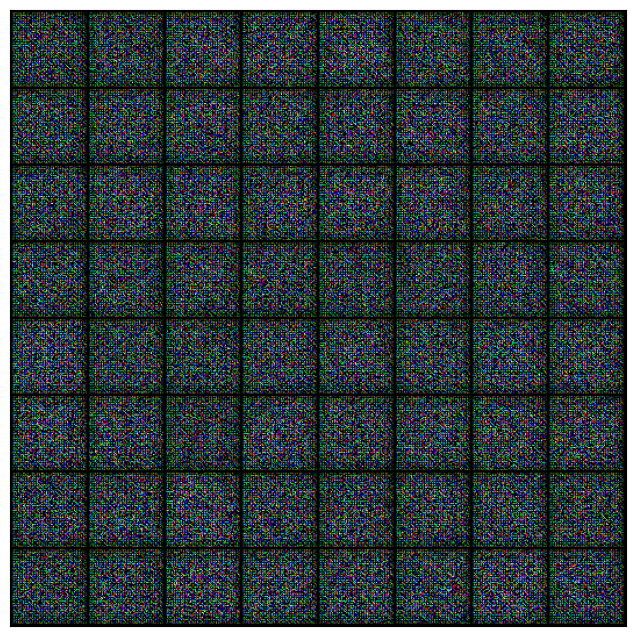

In [29]:
save_samples(0,fixed_latent)

In [30]:
jovian.commit(project='GAN-art', environment=None)

[jovian] Detected Colab notebook...
[jovian] jovian.commit() is no longer required on Google Colab. If you ran this notebook from Jovian, 
then just save this file in Colab using Ctrl+S/Cmd+S and it will be updated on Jovian. 
Also, you can also delete this cell, it's no longer necessary.


In [31]:
from tqdm.notebook import tqdm
import torch.nn.functional as F

In [32]:
def fit(epochs, lr, start_idx=1):
    torch.cuda.empty_cache()

    # Losses & scores
    losses_g = []
    losses_d = []
    real_scores = []
    fake_scores = []

    # Create optimizers
    opt_d = torch.optim.Adam(discriminator.parameters(), lr=lr, betas=(0.5, 0.999))
    opt_g = torch.optim.Adam(generator.parameters(), lr=lr, betas=(0.5, 0.999))

    for epoch in range(epochs):
        for real_images, _ in tqdm(train_dl):
            # Train discriminator
            loss_d, real_score, fake_score = train_discriminator(real_images, opt_d)
            # Train generator
            loss_g = train_generator(opt_g)

        # Record losses & scores
        losses_g.append(loss_g)
        losses_d.append(loss_d)
        real_scores.append(real_score)
        fake_scores.append(fake_score)

        # Log losses & scores (last batch)
        print("Epoch [{}/{}], loss_g: {:.4f}, loss_d: {:.4f}, real_score: {:.4f}, fake_score: {:.4f}".format(
            epoch+1, epochs, loss_g, loss_d, real_score, fake_score))

        # Save generated images
        save_samples(epoch+start_idx, fixed_latent, show=False)

    return losses_g, losses_d, real_scores, fake_scores

In [33]:
lr=5e-5
epochs=250 #will make 25 later

In [ ]:
history = fit(epochs, lr)


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [1/250], loss_g: 9.3769, loss_d: 0.2066, real_score: 0.8319, fake_score: 0.0031
Saving generated-images-0001.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [2/250], loss_g: 5.5756, loss_d: 0.2615, real_score: 0.9452, fake_score: 0.1829
Saving generated-images-0002.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [3/250], loss_g: 8.4422, loss_d: 0.6957, real_score: 0.8543, fake_score: 0.3843
Saving generated-images-0003.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [4/250], loss_g: 4.1919, loss_d: 3.5164, real_score: 0.0873, fake_score: 0.0081
Saving generated-images-0004.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [5/250], loss_g: 4.4799, loss_d: 0.4973, real_score: 0.8113, fake_score: 0.2311
Saving generated-images-0005.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [6/250], loss_g: 4.9930, loss_d: 1.3324, real_score: 0.9290, fake_score: 0.6524
Saving generated-images-0006.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [7/250], loss_g: 4.6325, loss_d: 0.9754, real_score: 0.8610, fake_score: 0.5081
Saving generated-images-0007.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [8/250], loss_g: 3.7087, loss_d: 0.9265, real_score: 0.8953, fake_score: 0.5419
Saving generated-images-0008.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [9/250], loss_g: 4.0408, loss_d: 0.3557, real_score: 0.7995, fake_score: 0.1063
Saving generated-images-0009.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [10/250], loss_g: 3.3035, loss_d: 0.3576, real_score: 0.8542, fake_score: 0.1674
Saving generated-images-0010.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [11/250], loss_g: 4.4931, loss_d: 0.5548, real_score: 0.6355, fake_score: 0.0154
Saving generated-images-0011.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [12/250], loss_g: 2.3971, loss_d: 2.4951, real_score: 0.1508, fake_score: 0.0071
Saving generated-images-0012.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [13/250], loss_g: 5.8437, loss_d: 1.0728, real_score: 0.9337, fake_score: 0.5906
Saving generated-images-0013.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [14/250], loss_g: 4.9706, loss_d: 0.6187, real_score: 0.8246, fake_score: 0.3225
Saving generated-images-0014.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [15/250], loss_g: 2.8344, loss_d: 0.4220, real_score: 0.8481, fake_score: 0.2035
Saving generated-images-0015.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [16/250], loss_g: 3.5491, loss_d: 0.4470, real_score: 0.8756, fake_score: 0.2533
Saving generated-images-0016.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [17/250], loss_g: 5.9927, loss_d: 1.1388, real_score: 0.8579, fake_score: 0.5736
Saving generated-images-0017.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [18/250], loss_g: 4.9314, loss_d: 0.3652, real_score: 0.9232, fake_score: 0.2238
Saving generated-images-0018.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [19/250], loss_g: 4.1029, loss_d: 0.2587, real_score: 0.8402, fake_score: 0.0652
Saving generated-images-0019.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [20/250], loss_g: 5.4804, loss_d: 0.7325, real_score: 0.9670, fake_score: 0.4695
Saving generated-images-0020.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [21/250], loss_g: 2.3285, loss_d: 0.1825, real_score: 0.9339, fake_score: 0.1017
Saving generated-images-0021.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [22/250], loss_g: 3.6940, loss_d: 0.4403, real_score: 0.8099, fake_score: 0.1858
Saving generated-images-0022.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [23/250], loss_g: 1.9547, loss_d: 0.2000, real_score: 0.8662, fake_score: 0.0445
Saving generated-images-0023.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [24/250], loss_g: 5.1073, loss_d: 0.4733, real_score: 0.8305, fake_score: 0.2263
Saving generated-images-0024.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [25/250], loss_g: 4.4314, loss_d: 0.8062, real_score: 0.7859, fake_score: 0.3972
Saving generated-images-0025.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [26/250], loss_g: 4.7939, loss_d: 0.5073, real_score: 0.8564, fake_score: 0.2734
Saving generated-images-0026.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [27/250], loss_g: 4.0480, loss_d: 0.1613, real_score: 0.8706, fake_score: 0.0143
Saving generated-images-0027.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [28/250], loss_g: 2.6601, loss_d: 0.5861, real_score: 0.6614, fake_score: 0.0855
Saving generated-images-0028.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [29/250], loss_g: 4.0838, loss_d: 0.2045, real_score: 0.8657, fake_score: 0.0346
Saving generated-images-0029.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [30/250], loss_g: 2.1667, loss_d: 0.1605, real_score: 0.9311, fake_score: 0.0764
Saving generated-images-0030.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [31/250], loss_g: 3.7220, loss_d: 0.4079, real_score: 0.7813, fake_score: 0.1207
Saving generated-images-0031.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [32/250], loss_g: 2.6588, loss_d: 0.4906, real_score: 0.6910, fake_score: 0.0448
Saving generated-images-0032.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [33/250], loss_g: 4.1990, loss_d: 0.2280, real_score: 0.8901, fake_score: 0.0954
Saving generated-images-0033.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [34/250], loss_g: 4.1516, loss_d: 0.3761, real_score: 0.7446, fake_score: 0.0255
Saving generated-images-0034.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [35/250], loss_g: 6.1313, loss_d: 0.6321, real_score: 0.9773, fake_score: 0.4066
Saving generated-images-0035.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [36/250], loss_g: 3.1327, loss_d: 0.3204, real_score: 0.7782, fake_score: 0.0432
Saving generated-images-0036.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [37/250], loss_g: 8.8826, loss_d: 1.4764, real_score: 0.9780, fake_score: 0.7090
Saving generated-images-0037.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [38/250], loss_g: 4.0747, loss_d: 0.5902, real_score: 0.7165, fake_score: 0.1526
Saving generated-images-0038.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [39/250], loss_g: 4.3361, loss_d: 0.5399, real_score: 0.8160, fake_score: 0.2368
Saving generated-images-0039.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [40/250], loss_g: 4.6304, loss_d: 0.1819, real_score: 0.9091, fake_score: 0.0774
Saving generated-images-0040.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [41/250], loss_g: 3.6604, loss_d: 0.4361, real_score: 0.7707, fake_score: 0.1230
Saving generated-images-0041.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [42/250], loss_g: 5.2185, loss_d: 0.8229, real_score: 0.9334, fake_score: 0.4892
Saving generated-images-0042.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [43/250], loss_g: 3.4846, loss_d: 0.4000, real_score: 0.8117, fake_score: 0.1513
Saving generated-images-0043.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [44/250], loss_g: 2.4381, loss_d: 0.7789, real_score: 0.5263, fake_score: 0.0258
Saving generated-images-0044.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [45/250], loss_g: 4.9238, loss_d: 0.6956, real_score: 0.8431, fake_score: 0.3609
Saving generated-images-0045.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [46/250], loss_g: 3.7745, loss_d: 0.3880, real_score: 0.9070, fake_score: 0.2280
Saving generated-images-0046.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [47/250], loss_g: 4.1570, loss_d: 0.3507, real_score: 0.8526, fake_score: 0.1559
Saving generated-images-0047.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [48/250], loss_g: 5.4235, loss_d: 0.8094, real_score: 0.9434, fake_score: 0.4569
Saving generated-images-0048.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [49/250], loss_g: 2.9084, loss_d: 0.3235, real_score: 0.9515, fake_score: 0.2103
Saving generated-images-0049.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [50/250], loss_g: 4.3392, loss_d: 0.3265, real_score: 0.8331, fake_score: 0.1170
Saving generated-images-0050.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [51/250], loss_g: 3.1980, loss_d: 0.4475, real_score: 0.7818, fake_score: 0.1452
Saving generated-images-0051.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [52/250], loss_g: 2.4476, loss_d: 0.4051, real_score: 0.8085, fake_score: 0.1488
Saving generated-images-0052.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [53/250], loss_g: 7.1433, loss_d: 0.9172, real_score: 0.8500, fake_score: 0.4577
Saving generated-images-0053.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [54/250], loss_g: 4.8142, loss_d: 0.4898, real_score: 0.8559, fake_score: 0.2539
Saving generated-images-0054.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [55/250], loss_g: 5.9064, loss_d: 0.6544, real_score: 0.9353, fake_score: 0.4069
Saving generated-images-0055.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [56/250], loss_g: 2.4378, loss_d: 0.2312, real_score: 0.8592, fake_score: 0.0603
Saving generated-images-0056.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [57/250], loss_g: 3.2827, loss_d: 0.1960, real_score: 0.9169, fake_score: 0.0913
Saving generated-images-0057.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [58/250], loss_g: 4.5871, loss_d: 0.6412, real_score: 0.8461, fake_score: 0.3254
Saving generated-images-0058.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [59/250], loss_g: 2.6347, loss_d: 0.4965, real_score: 0.6879, fake_score: 0.0401
Saving generated-images-0059.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [60/250], loss_g: 5.2300, loss_d: 0.2121, real_score: 0.9595, fake_score: 0.1461
Saving generated-images-0060.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [61/250], loss_g: 4.6544, loss_d: 0.3412, real_score: 0.9337, fake_score: 0.2218
Saving generated-images-0061.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [62/250], loss_g: 4.1279, loss_d: 0.3512, real_score: 0.7953, fake_score: 0.0898
Saving generated-images-0062.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [63/250], loss_g: 5.4835, loss_d: 0.5588, real_score: 0.8169, fake_score: 0.2702
Saving generated-images-0063.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [64/250], loss_g: 2.9931, loss_d: 0.3536, real_score: 0.9901, fake_score: 0.2362
Saving generated-images-0064.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [65/250], loss_g: 3.9860, loss_d: 0.4052, real_score: 0.8091, fake_score: 0.1491
Saving generated-images-0065.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [66/250], loss_g: 6.7956, loss_d: 0.5125, real_score: 0.9795, fake_score: 0.3493
Saving generated-images-0066.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [67/250], loss_g: 4.9546, loss_d: 0.3981, real_score: 0.8509, fake_score: 0.1921
Saving generated-images-0067.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [68/250], loss_g: 3.4698, loss_d: 0.4416, real_score: 0.7861, fake_score: 0.1559
Saving generated-images-0068.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [69/250], loss_g: 4.0652, loss_d: 0.3346, real_score: 0.8894, fake_score: 0.1809
Saving generated-images-0069.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [70/250], loss_g: 6.0841, loss_d: 0.3787, real_score: 0.9387, fake_score: 0.2391
Saving generated-images-0070.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [71/250], loss_g: 5.5801, loss_d: 0.2299, real_score: 0.8185, fake_score: 0.0098
Saving generated-images-0071.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [72/250], loss_g: 2.6777, loss_d: 0.4307, real_score: 0.7237, fake_score: 0.0681
Saving generated-images-0072.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [73/250], loss_g: 3.5240, loss_d: 0.4535, real_score: 0.6939, fake_score: 0.0291
Saving generated-images-0073.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [74/250], loss_g: 6.6281, loss_d: 0.4637, real_score: 0.9493, fake_score: 0.3048
Saving generated-images-0074.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [75/250], loss_g: 6.7750, loss_d: 0.4907, real_score: 0.9538, fake_score: 0.3238
Saving generated-images-0075.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [76/250], loss_g: 1.8481, loss_d: 0.5274, real_score: 0.6955, fake_score: 0.0804
Saving generated-images-0076.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [77/250], loss_g: 3.5815, loss_d: 0.3199, real_score: 0.8161, fake_score: 0.0932
Saving generated-images-0077.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [78/250], loss_g: 1.6953, loss_d: 0.4405, real_score: 0.7327, fake_score: 0.0989
Saving generated-images-0078.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [79/250], loss_g: 3.3119, loss_d: 0.1162, real_score: 0.9281, fake_score: 0.0375
Saving generated-images-0079.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [80/250], loss_g: 5.6600, loss_d: 0.4365, real_score: 0.9670, fake_score: 0.3002
Saving generated-images-0080.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [81/250], loss_g: 3.7020, loss_d: 0.2998, real_score: 0.8653, fake_score: 0.1320
Saving generated-images-0081.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [82/250], loss_g: 4.3583, loss_d: 0.5407, real_score: 0.8030, fake_score: 0.2313
Saving generated-images-0082.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [83/250], loss_g: 7.5558, loss_d: 0.7456, real_score: 0.9259, fake_score: 0.4301
Saving generated-images-0083.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [84/250], loss_g: 1.9177, loss_d: 0.6174, real_score: 0.6125, fake_score: 0.0415
Saving generated-images-0084.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [85/250], loss_g: 2.0043, loss_d: 0.4697, real_score: 0.6962, fake_score: 0.0690
Saving generated-images-0085.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [86/250], loss_g: 7.8968, loss_d: 0.5704, real_score: 0.9646, fake_score: 0.3660
Saving generated-images-0086.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [87/250], loss_g: 8.6447, loss_d: 0.4845, real_score: 0.6705, fake_score: 0.0013
Saving generated-images-0087.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [88/250], loss_g: 3.1704, loss_d: 0.3092, real_score: 0.8562, fake_score: 0.1268
Saving generated-images-0088.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [89/250], loss_g: 4.0083, loss_d: 0.3240, real_score: 0.7859, fake_score: 0.0380
Saving generated-images-0089.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [90/250], loss_g: 5.6992, loss_d: 0.5318, real_score: 0.9588, fake_score: 0.3481
Saving generated-images-0090.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [91/250], loss_g: 3.4620, loss_d: 0.2600, real_score: 0.8866, fake_score: 0.1055
Saving generated-images-0091.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [92/250], loss_g: 5.0659, loss_d: 0.3254, real_score: 0.9507, fake_score: 0.2183
Saving generated-images-0092.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [93/250], loss_g: 3.2586, loss_d: 0.2462, real_score: 0.8348, fake_score: 0.0345
Saving generated-images-0093.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [94/250], loss_g: 2.8385, loss_d: 0.1972, real_score: 0.8592, fake_score: 0.0370
Saving generated-images-0094.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [95/250], loss_g: 9.8411, loss_d: 1.2988, real_score: 0.9954, fake_score: 0.6629
Saving generated-images-0095.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [96/250], loss_g: 4.4121, loss_d: 0.2281, real_score: 0.9594, fake_score: 0.1572
Saving generated-images-0096.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [97/250], loss_g: 5.2445, loss_d: 0.1577, real_score: 0.8781, fake_score: 0.0134
Saving generated-images-0097.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [98/250], loss_g: 8.5495, loss_d: 0.6808, real_score: 0.9785, fake_score: 0.4077
Saving generated-images-0098.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [99/250], loss_g: 6.0117, loss_d: 0.3530, real_score: 0.9216, fake_score: 0.2033
Saving generated-images-0099.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [100/250], loss_g: 4.7613, loss_d: 0.3960, real_score: 0.9643, fake_score: 0.2527
Saving generated-images-0100.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [101/250], loss_g: 2.3155, loss_d: 0.5508, real_score: 0.6977, fake_score: 0.1163
Saving generated-images-0101.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [102/250], loss_g: 3.2963, loss_d: 0.2369, real_score: 0.8988, fake_score: 0.1118
Saving generated-images-0102.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [103/250], loss_g: 4.4417, loss_d: 0.1871, real_score: 0.9346, fake_score: 0.1070
Saving generated-images-0103.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [104/250], loss_g: 3.2273, loss_d: 0.5353, real_score: 0.8414, fake_score: 0.2387
Saving generated-images-0104.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [105/250], loss_g: 1.4027, loss_d: 1.4754, real_score: 0.2912, fake_score: 0.0103
Saving generated-images-0105.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [106/250], loss_g: 5.0968, loss_d: 0.3041, real_score: 0.9431, fake_score: 0.1997
Saving generated-images-0106.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [107/250], loss_g: 4.0521, loss_d: 0.2945, real_score: 0.9789, fake_score: 0.2205
Saving generated-images-0107.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [108/250], loss_g: 4.6667, loss_d: 0.2054, real_score: 0.9516, fake_score: 0.1364
Saving generated-images-0108.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [109/250], loss_g: 4.4242, loss_d: 0.3077, real_score: 0.8602, fake_score: 0.1298
Saving generated-images-0109.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [110/250], loss_g: 5.3336, loss_d: 0.3627, real_score: 0.8958, fake_score: 0.2069
Saving generated-images-0110.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [111/250], loss_g: 4.1181, loss_d: 0.2933, real_score: 0.9165, fake_score: 0.1657
Saving generated-images-0111.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [112/250], loss_g: 7.2341, loss_d: 0.8145, real_score: 0.9679, fake_score: 0.4710
Saving generated-images-0112.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [113/250], loss_g: 4.1245, loss_d: 0.2966, real_score: 0.8836, fake_score: 0.1409
Saving generated-images-0113.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [114/250], loss_g: 4.4875, loss_d: 0.1481, real_score: 0.8988, fake_score: 0.0291
Saving generated-images-0114.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [115/250], loss_g: 2.6962, loss_d: 0.2715, real_score: 0.8353, fake_score: 0.0726
Saving generated-images-0115.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [116/250], loss_g: 2.7655, loss_d: 0.1917, real_score: 0.8848, fake_score: 0.0599
Saving generated-images-0116.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [117/250], loss_g: 4.3503, loss_d: 0.4847, real_score: 0.8121, fake_score: 0.2160
Saving generated-images-0117.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [118/250], loss_g: 2.5643, loss_d: 0.4376, real_score: 0.6965, fake_score: 0.0313
Saving generated-images-0118.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [119/250], loss_g: 4.4778, loss_d: 0.1332, real_score: 0.9542, fake_score: 0.0782
Saving generated-images-0119.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [120/250], loss_g: 3.8584, loss_d: 0.2193, real_score: 0.8888, fake_score: 0.0811
Saving generated-images-0120.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [121/250], loss_g: 8.1184, loss_d: 0.5088, real_score: 0.9527, fake_score: 0.3232
Saving generated-images-0121.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [122/250], loss_g: 5.5868, loss_d: 0.2923, real_score: 0.9863, fake_score: 0.2177
Saving generated-images-0122.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [123/250], loss_g: 2.5575, loss_d: 0.2974, real_score: 0.7963, fake_score: 0.0446
Saving generated-images-0123.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [124/250], loss_g: 6.6488, loss_d: 0.4324, real_score: 0.9253, fake_score: 0.2518
Saving generated-images-0124.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [125/250], loss_g: 3.9470, loss_d: 0.4001, real_score: 0.8683, fake_score: 0.1552
Saving generated-images-0125.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [126/250], loss_g: 5.1790, loss_d: 0.2959, real_score: 0.9181, fake_score: 0.1676
Saving generated-images-0126.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [127/250], loss_g: 2.8789, loss_d: 1.0038, real_score: 0.4122, fake_score: 0.0009
Saving generated-images-0127.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [128/250], loss_g: 3.6881, loss_d: 0.1210, real_score: 0.9398, fake_score: 0.0518
Saving generated-images-0128.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [129/250], loss_g: 4.0463, loss_d: 0.2391, real_score: 0.8972, fake_score: 0.1081
Saving generated-images-0129.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [130/250], loss_g: 6.8441, loss_d: 0.4753, real_score: 0.9836, fake_score: 0.3234
Saving generated-images-0130.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [131/250], loss_g: 6.2752, loss_d: 1.5918, real_score: 0.9217, fake_score: 0.4692
Saving generated-images-0131.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [132/250], loss_g: 3.5312, loss_d: 0.2944, real_score: 0.8417, fake_score: 0.0900
Saving generated-images-0132.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [133/250], loss_g: 3.7162, loss_d: 0.1918, real_score: 0.9299, fake_score: 0.1033
Saving generated-images-0133.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [134/250], loss_g: 5.7983, loss_d: 0.5834, real_score: 0.9370, fake_score: 0.3647
Saving generated-images-0134.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [135/250], loss_g: 3.5948, loss_d: 0.2240, real_score: 0.9164, fake_score: 0.1099
Saving generated-images-0135.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [136/250], loss_g: 6.3731, loss_d: 0.3828, real_score: 0.9596, fake_score: 0.2629
Saving generated-images-0136.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [137/250], loss_g: 3.3873, loss_d: 0.2177, real_score: 0.8535, fake_score: 0.0478
Saving generated-images-0137.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [138/250], loss_g: 4.2606, loss_d: 0.2414, real_score: 0.9497, fake_score: 0.1515
Saving generated-images-0138.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [139/250], loss_g: 6.5629, loss_d: 0.3549, real_score: 0.9568, fake_score: 0.2465
Saving generated-images-0139.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [140/250], loss_g: 9.4107, loss_d: 1.0936, real_score: 0.9711, fake_score: 0.5795
Saving generated-images-0140.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [141/250], loss_g: 6.5828, loss_d: 0.4300, real_score: 0.9801, fake_score: 0.2916
Saving generated-images-0141.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [142/250], loss_g: 4.1718, loss_d: 0.3069, real_score: 0.8584, fake_score: 0.1210
Saving generated-images-0142.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [143/250], loss_g: 4.1442, loss_d: 0.1370, real_score: 0.9369, fake_score: 0.0651
Saving generated-images-0143.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [144/250], loss_g: 4.7779, loss_d: 0.1157, real_score: 0.9514, fake_score: 0.0610
Saving generated-images-0144.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [145/250], loss_g: 2.7655, loss_d: 0.3447, real_score: 0.8088, fake_score: 0.0991
Saving generated-images-0145.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [146/250], loss_g: 3.2344, loss_d: 0.2696, real_score: 0.8711, fake_score: 0.1074
Saving generated-images-0146.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [147/250], loss_g: 4.8764, loss_d: 0.1467, real_score: 0.9423, fake_score: 0.0785
Saving generated-images-0147.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [148/250], loss_g: 3.9281, loss_d: 0.2693, real_score: 0.9022, fake_score: 0.1378
Saving generated-images-0148.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [149/250], loss_g: 5.0568, loss_d: 0.1073, real_score: 0.9609, fake_score: 0.0622
Saving generated-images-0149.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [150/250], loss_g: 0.8041, loss_d: 0.6193, real_score: 0.5876, fake_score: 0.0132
Saving generated-images-0150.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [151/250], loss_g: 2.2716, loss_d: 0.3795, real_score: 0.7713, fake_score: 0.0774
Saving generated-images-0151.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [152/250], loss_g: 5.6517, loss_d: 0.2099, real_score: 0.9828, fake_score: 0.1602
Saving generated-images-0152.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [153/250], loss_g: 3.7792, loss_d: 0.1925, real_score: 0.9318, fake_score: 0.1028
Saving generated-images-0153.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [154/250], loss_g: 3.8432, loss_d: 0.2032, real_score: 0.8964, fake_score: 0.0766
Saving generated-images-0154.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [155/250], loss_g: 3.1315, loss_d: 0.1740, real_score: 0.8703, fake_score: 0.0264
Saving generated-images-0155.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [156/250], loss_g: 4.5546, loss_d: 0.2112, real_score: 0.9658, fake_score: 0.1514
Saving generated-images-0156.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [157/250], loss_g: 3.9942, loss_d: 0.1133, real_score: 0.9350, fake_score: 0.0416
Saving generated-images-0157.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [158/250], loss_g: 8.4465, loss_d: 1.0004, real_score: 0.9501, fake_score: 0.5055
Saving generated-images-0158.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [159/250], loss_g: 7.1145, loss_d: 1.1270, real_score: 0.9949, fake_score: 0.5717
Saving generated-images-0159.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [160/250], loss_g: 3.5657, loss_d: 0.1881, real_score: 0.8838, fake_score: 0.0492
Saving generated-images-0160.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [161/250], loss_g: 3.2463, loss_d: 0.3061, real_score: 0.8883, fake_score: 0.1495
Saving generated-images-0161.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [162/250], loss_g: 5.0566, loss_d: 0.1970, real_score: 0.9771, fake_score: 0.1492
Saving generated-images-0162.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [163/250], loss_g: 5.0953, loss_d: 0.0926, real_score: 0.9500, fake_score: 0.0380
Saving generated-images-0163.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [164/250], loss_g: 4.9981, loss_d: 0.0763, real_score: 0.9823, fake_score: 0.0547
Saving generated-images-0164.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [165/250], loss_g: 2.5160, loss_d: 0.2091, real_score: 0.8810, fake_score: 0.0678
Saving generated-images-0165.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [166/250], loss_g: 0.5716, loss_d: 1.1065, real_score: 0.3816, fake_score: 0.0037
Saving generated-images-0166.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [167/250], loss_g: 3.5455, loss_d: 1.1139, real_score: 0.4614, fake_score: 0.0068
Saving generated-images-0167.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [168/250], loss_g: 3.4388, loss_d: 0.2425, real_score: 0.9263, fake_score: 0.1367
Saving generated-images-0168.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [169/250], loss_g: 1.6654, loss_d: 0.3979, real_score: 0.7320, fake_score: 0.0388
Saving generated-images-0169.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [170/250], loss_g: 4.1402, loss_d: 0.1651, real_score: 0.9373, fake_score: 0.0863
Saving generated-images-0170.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [171/250], loss_g: 3.6027, loss_d: 0.1243, real_score: 0.9689, fake_score: 0.0839
Saving generated-images-0171.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [172/250], loss_g: 2.3498, loss_d: 1.0517, real_score: 0.4945, fake_score: 0.0062
Saving generated-images-0172.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [173/250], loss_g: 5.2451, loss_d: 0.1693, real_score: 0.9598, fake_score: 0.1016
Saving generated-images-0173.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [174/250], loss_g: 4.7795, loss_d: 0.2705, real_score: 0.9365, fake_score: 0.1665
Saving generated-images-0174.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [175/250], loss_g: 1.4913, loss_d: 0.3308, real_score: 0.7860, fake_score: 0.0638
Saving generated-images-0175.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [176/250], loss_g: 4.1458, loss_d: 0.2323, real_score: 0.9467, fake_score: 0.1475
Saving generated-images-0176.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [177/250], loss_g: 4.2681, loss_d: 0.1324, real_score: 0.9558, fake_score: 0.0777
Saving generated-images-0177.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [178/250], loss_g: 2.1454, loss_d: 0.1893, real_score: 0.8733, fake_score: 0.0433
Saving generated-images-0178.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [179/250], loss_g: 4.8350, loss_d: 0.1941, real_score: 0.9719, fake_score: 0.1392
Saving generated-images-0179.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [180/250], loss_g: 6.1804, loss_d: 0.4126, real_score: 0.9030, fake_score: 0.2285
Saving generated-images-0180.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [181/250], loss_g: 2.9948, loss_d: 0.2372, real_score: 0.8684, fake_score: 0.0774
Saving generated-images-0181.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [182/250], loss_g: 5.3633, loss_d: 0.2778, real_score: 0.8760, fake_score: 0.0935
Saving generated-images-0182.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [183/250], loss_g: 4.2824, loss_d: 0.1413, real_score: 0.9783, fake_score: 0.1035
Saving generated-images-0183.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [184/250], loss_g: 3.5238, loss_d: 0.1625, real_score: 0.9343, fake_score: 0.0831
Saving generated-images-0184.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [185/250], loss_g: 4.6425, loss_d: 0.1949, real_score: 0.9315, fake_score: 0.1045
Saving generated-images-0185.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [186/250], loss_g: 4.7437, loss_d: 0.2117, real_score: 0.8366, fake_score: 0.0172
Saving generated-images-0186.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [187/250], loss_g: 4.0452, loss_d: 0.0714, real_score: 0.9848, fake_score: 0.0520
Saving generated-images-0187.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [188/250], loss_g: 4.1431, loss_d: 0.0782, real_score: 0.9536, fake_score: 0.0292
Saving generated-images-0188.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [189/250], loss_g: 2.4431, loss_d: 0.2328, real_score: 0.8285, fake_score: 0.0253
Saving generated-images-0189.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [190/250], loss_g: 3.5351, loss_d: 0.1707, real_score: 0.9196, fake_score: 0.0764
Saving generated-images-0190.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [191/250], loss_g: 2.1033, loss_d: 0.1981, real_score: 0.8970, fake_score: 0.0751
Saving generated-images-0191.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [192/250], loss_g: 3.7330, loss_d: 0.1618, real_score: 0.9412, fake_score: 0.0888
Saving generated-images-0192.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [193/250], loss_g: 1.4409, loss_d: 0.2447, real_score: 0.8514, fake_score: 0.0600
Saving generated-images-0193.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [194/250], loss_g: 3.7386, loss_d: 0.3627, real_score: 0.8268, fake_score: 0.1073
Saving generated-images-0194.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [195/250], loss_g: 4.0063, loss_d: 0.2520, real_score: 0.9474, fake_score: 0.1560
Saving generated-images-0195.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [196/250], loss_g: 3.4575, loss_d: 0.1879, real_score: 0.8747, fake_score: 0.0396
Saving generated-images-0196.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [197/250], loss_g: 2.6650, loss_d: 0.2252, real_score: 0.8476, fake_score: 0.0372
Saving generated-images-0197.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [198/250], loss_g: 4.0502, loss_d: 0.1056, real_score: 0.9635, fake_score: 0.0632
Saving generated-images-0198.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [199/250], loss_g: 3.5331, loss_d: 0.1482, real_score: 0.9183, fake_score: 0.0550
Saving generated-images-0199.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [200/250], loss_g: 4.8832, loss_d: 0.1372, real_score: 0.9140, fake_score: 0.0407
Saving generated-images-0200.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [201/250], loss_g: 3.6483, loss_d: 0.1684, real_score: 0.8746, fake_score: 0.0254
Saving generated-images-0201.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [202/250], loss_g: 3.1499, loss_d: 0.1641, real_score: 0.8756, fake_score: 0.0190
Saving generated-images-0202.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [203/250], loss_g: 8.1573, loss_d: 0.5198, real_score: 0.9931, fake_score: 0.3499
Saving generated-images-0203.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [204/250], loss_g: 7.5357, loss_d: 1.6831, real_score: 0.9751, fake_score: 0.6661
Saving generated-images-0204.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [205/250], loss_g: 3.1936, loss_d: 0.2630, real_score: 0.8720, fake_score: 0.0971
Saving generated-images-0205.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [206/250], loss_g: 2.9163, loss_d: 0.2738, real_score: 0.8148, fake_score: 0.0368
Saving generated-images-0206.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [207/250], loss_g: 4.0931, loss_d: 0.1275, real_score: 0.9572, fake_score: 0.0744
Saving generated-images-0207.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [208/250], loss_g: 2.3475, loss_d: 0.2155, real_score: 0.8744, fake_score: 0.0661
Saving generated-images-0208.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [209/250], loss_g: 4.2399, loss_d: 0.1672, real_score: 0.9391, fake_score: 0.0849
Saving generated-images-0209.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [210/250], loss_g: 3.9957, loss_d: 0.0957, real_score: 0.9751, fake_score: 0.0636
Saving generated-images-0210.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [211/250], loss_g: 5.0498, loss_d: 0.1021, real_score: 0.9270, fake_score: 0.0229
Saving generated-images-0211.png


  0%|          | 0/24 [00:00<?, ?it/s]

Epoch [212/250], loss_g: 4.1818, loss_d: 0.0870, real_score: 0.9657, fake_score: 0.0487
Saving generated-images-0212.png


  0%|          | 0/24 [00:00<?, ?it/s]

In [35]:
losses_g, losses_d, real_scores, fake_scores = history


In [43]:
torch.save(generator.state_dict(), 'G.pth')
torch.save(discriminator.state_dict(), 'D.pth')

In [44]:
from IPython.display import Image


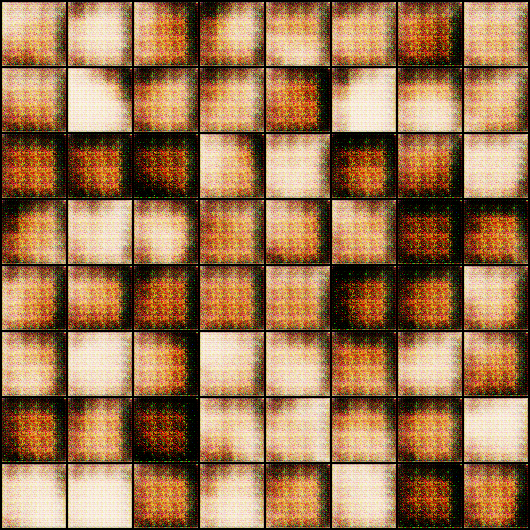

In [45]:
Image('./generated/generated-images-0005.png')


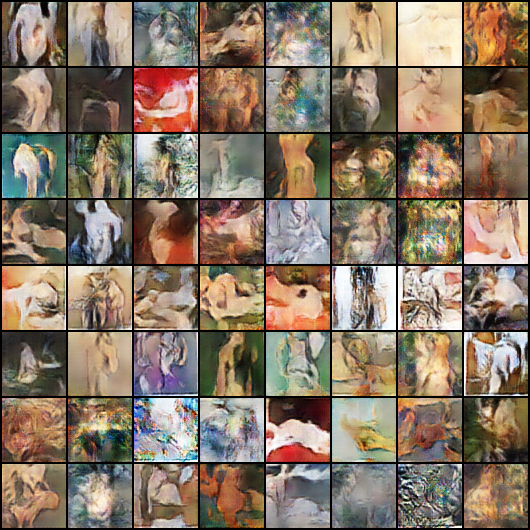

In [47]:
Image('./generated/generated-images-0219.png')


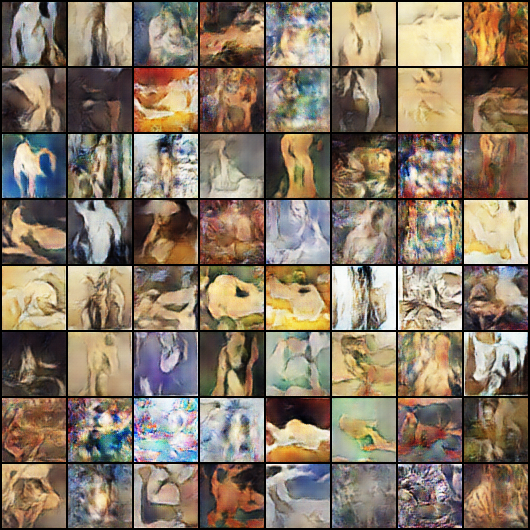

In [48]:
Image('./generated/generated-images-0250.png')


In [37]:
import cv2
import os

vid_fname = 'gans_training.avi'

files = [os.path.join(sample_dir, f) for f in os.listdir(sample_dir) if 'generated' in f]
files.sort()

out = cv2.VideoWriter(vid_fname,cv2.VideoWriter_fourcc(*'MP4V'), 1, (530,530))
[out.write(cv2.imread(fname)) for fname in files]
out.release()

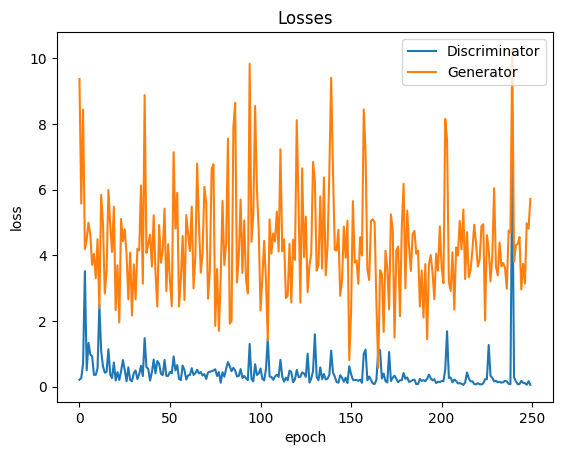

In [38]:
plt.plot(losses_d, '-')
plt.plot(losses_g, '-')
plt.xlabel('epoch')
plt.ylabel('loss')
plt.legend(['Discriminator', 'Generator'])
plt.title('Losses');

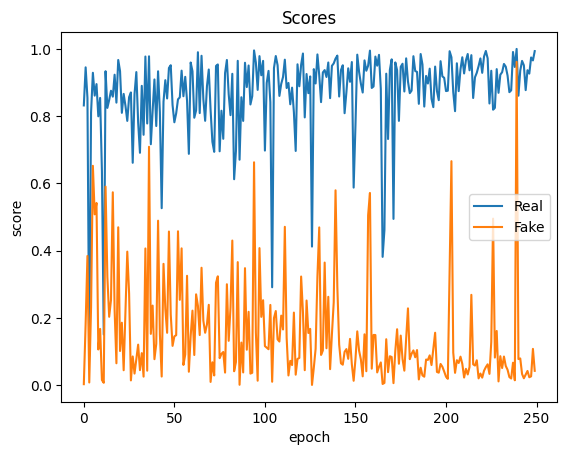

In [39]:
plt.plot(real_scores, '-')
plt.plot(fake_scores, '-')
plt.xlabel('epoch')
plt.ylabel('score')
plt.legend(['Real', 'Fake'])
plt.title('Scores');